# 问题梳理

因变量：耗电量、冷却负载、系统效率

自变量：
- 设备状态：12个，冷水泵状态、冷凝泵状态、冷却装置状态和冷却塔状态
- 设备转速：3个，冷水泵转速、冷凝水泵转速、冷却塔风扇转速
- 其他：温度等不可控参数

### 回归

实际上是研究上述因变量与自变量之间的关系，可利用上述自变量对耗电量与冷却负载做回归，系统效率可直接根据 耗电量/冷却负载 计算得出。

其中耗电量可以由各部分功率相加得到，因此对各部分设备分别建立回归模型。

该问得到的回归方程是后续优化的基础，其中总耗电量回归方程作为后续线性规划的目标函数。

### 最优化-线性规划

为线性规划问题，分别将设备状态和转速作为决策变量

目标函数设为总耗电量回归方程，并且根据决策变量的不同进行转换

该部分重点为约束条件的设立，根据问题中的不同需求设立不同的约束条件

#  模型建立

## 导入相关的包

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

from scipy.optimize import minimize
from scipy import optimize as op 
import pulp as plp

## EDA

In [3]:
df = pd.read_csv('./中央空调系统分析问题/附件1：CACS_data_1.csv')
df.head()

,Time Stamp,chwrhdr,chwshdr,chwsfhdr,cwshdr,cwrhdr,cwsfhdr,ch1kw,ch2kw,chwp1kw,...,cwp_pc,chwp_pc,ct_pc,ct_eff_sp,ch3kw,chwp3kw,chwp4kw,chwp3stat,chwp4stat,dch
0,10/4/2016 10:17,14.683798,9.320504,1191.451904,27.761873,30.553684,2587.563477,96.768013,114.176010,4.000,...,100.0,16.722687,40.465801,0.039222,0.0,0.000680,0.007094,0,0,5.363294
1,10/4/2016 10:18,14.696507,9.257778,1189.690796,27.803486,30.616804,2591.855225,96.768013,113.664009,4.048,...,100.0,17.197979,40.539692,0.039320,0.0,0.000961,0.007344,0,0,5.438729
2,10/4/2016 10:19,14.629988,9.230712,1187.048950,27.694603,30.561329,2592.928467,96.768013,116.736015,4.080,...,100.0,17.645538,40.595840,0.038965,0.0,0.000500,0.007188,0,0,5.399276
3,10/4/2016 10:20,14.629405,9.155090,1171.638550,27.731785,30.525755,2586.489990,96.256012,115.200012,4.080,...,100.0,18.147306,40.646667,0.039106,0.0,0.000691,0.008250,0,0,5.474315
4,10/4/2016 10:21,14.629988,9.131114,1193.213257,27.661123,30.532192,2592.391846,95.744003,114.176010,4.160,...,100.0,19.115679,40.717670,0.038866,0.0,0.000609,0.008188,0,0,5.498874


In [4]:
df.shape

(20593, 51)

### 缺失值探查

查看缺失值情况:无缺失值

In [5]:
df.isnull().sum().sum()

0

### 异常值

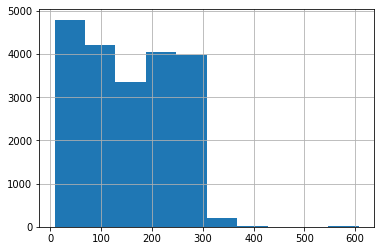

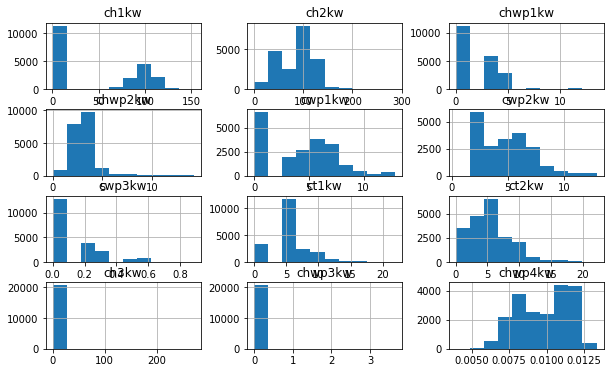

In [478]:
df.systotpower.hist()
df[df.columns[df.columns.str.endswith('kw')]].hist(figsize = (10,6))
plt.show()

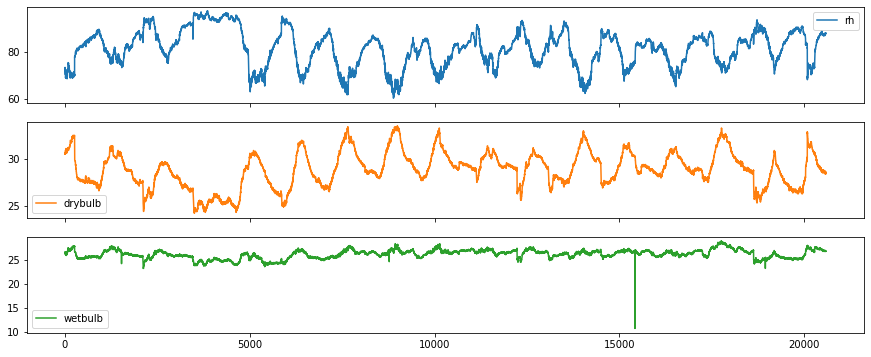

In [6]:
df[["rh","drybulb","wetbulb"]].plot(subplots = True,figsize = (15,6),sharex = True)
plt.show()

In [7]:
timestamp = df["Time Stamp"]
df = df.drop(columns="Time Stamp")

基于3倍分位数间距剔除异常值：

In [8]:
df_p = df[["rh","drybulb","wetbulb"]]
quantile = 3*(df_p.quantile(0.75) - df_p.quantile(0.25))
outlier_index = ((df_p <df_p.quantile(0.25) -quantile) | (df_p > df_p.quantile(0.75)+quantile)).any(axis = 1)
print("异常值个数：",outlier_index.sum())


异常值个数： 1


In [9]:
df_clean = df[~outlier_index]

# 回归分析（问题1）

In [10]:
#列名
cols = pd.Series(df.columns)

#流入流出冷凝装置的水温差
df_clean['dcw'] = df_clean.cwshdr - df_clean.cwrhdr

/Users/jane/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## 因变量为冷却负载

- 因变量：冷却负载
- 自变量：相对湿度、干球温度、湿球温度、转速（3个）、水流速度（2个）、温度差（2个）

首先查看因变量与上述自变量之间的相关性：

In [261]:
y_load = df_clean['loadsys']
x_load = df_clean[['chwp_pc','cwp_pc','ct_pc',"rh","drybulb","wetbulb",'dch','dcw']]
# , 'chwsfhdr']
pd.concat([y_load,x_load],axis = 1).corr()

,loadsys,chwp_pc,cwp_pc,ct_pc,rh,drybulb,wetbulb,dch,dcw
loadsys,1.000000,0.608249,0.860808,0.682693,-0.374505,0.422690,0.333071,0.857066,-0.785538
chwp_pc,0.608249,1.000000,0.655077,0.493026,-0.106088,0.190615,0.232955,0.377535,-0.450605
cwp_pc,0.860808,0.655077,1.000000,0.590214,-0.273225,0.312233,0.248792,0.806423,-0.570224
ct_pc,0.682693,0.493026,0.590214,1.000000,-0.153156,0.222152,0.222582,0.512688,-0.548485
rh,-0.374505,-0.106088,-0.273225,-0.153156,1.000000,-0.901568,-0.492282,-0.391132,0.337019
drybulb,0.422690,0.190615,0.312233,0.222152,-0.901568,1.000000,0.816881,0.394829,-0.377866
wetbulb,0.333071,0.232955,0.248792,0.222582,-0.492282,0.816881,1.000000,0.260584,-0.295749
dch,0.857066,0.377535,0.806423,0.512688,-0.391132,0.394829,0.260584,1.000000,-0.832215
dcw,-0.785538,-0.450605,-0.570224,-0.548485,0.337019,-0.377866,-0.295749,-0.832215,1.000000


线性回归模型：

自变量添加各装置状态

In [262]:
x_load_add_stat = df_clean[df.columns[df.columns.str.endswith('stat')].tolist() + x_load.columns.tolist()]

In [110]:
lr_load = LinearRegression()

交叉验证：

In [112]:
scores = cross_val_score(lr_load,x_load_add_stat,y_load,cv = 10)
print("平均分数为：",scores.mean())

平均分数为： 0.9737679464888405


交叉验证结果来看，模型拟合效果较好。

In [276]:
# x_load = df_clean[['chwp_pc','cwp_pc','ct_pc',"rh","drybulb",'dch','dcw']]
x_load = df_clean[['chwp_pc','cwp_pc','ct_pc']]
x_load_add_stat = df_clean[df.columns[df.columns.str.endswith('stat')].tolist() + x_load.columns.tolist()]
x_load_add_stat = sm.add_constant(x_load_add_stat,has_constant = 'add')
lr_load = sm.OLS(y_load,x_load_add_stat).fit()
lr_load.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                loadsys   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 5.273e+04
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:56:07   Log-Likelihood:                -97423.
No. Observations:               20592   AIC:                         1.949e+05
Df Residuals:                   20578   BIC:                         1.950e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.7307      1.025    -37.799      0.000     -40.739     -36.722
ch1stat      153.2906      3.813     40.197      0.000     145.816     160.765
ch2stat       40.3186      9.158      4.402      0.000      22.368      58.270
ch3stat      147.0075     27.807      5.287      0.000      92.503     201.512
chwp1stat     -9.8159      3.923     -2.502      0.012     -17.506      -2.126
chwp2stat     93.9857      9.279     10.129      0.000      75.798     112.174
cwp1stat      74.5677      1.543     48.331      0.000      71.544      77.592
cwp2stat     -38.7307      1.025    -37.799      0.000     -40.739     -36.722
cwp3stat       8.3101      1.131      7.350      0.000       6.094      10.526
ct1stat       25.9873      1.547     16.803      0.000      22.956      29.019
ct2stat       28.8633      1.542     18.718      0.000      25.841      31.886
chwp3stat     -0.9190     13.748     -0.067      0.947     -27.867      26.029
chwp4stat     -0.9190     13.748     -0.067      0.947     -27.867      26.029
chwp_pc        0.9544      0.016     58.547      0.000       0.922       0.986
cwp_pc         1.7648      0.014    128.434      0.000       1.738       1.792
ct_pc          0.3248      0.015     21.762      0.000       0.296       0.354
==============================================================================
Omnibus:                     4640.024   Durbin-Watson:                   0.269
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101832.182
Skew:                          -0.543   Prob(JB):                         0.00
Kurtosis:                      13.840   Cond. No.                     8.08e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.32e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 因变量为功率

这里定义因变量为各部分的功率

### 冷凝水泵（cw）

- 因变量：冷凝水泵功率
- 自变量：(冷凝装置)水温差、水流速度；转速；相对湿度、干球温度、湿球温度;状态

取出与冷凝水泵相关的数据：

In [107]:
df_cw = df_clean[cols[cols.str.startswith('cw')].tolist()]

In [109]:
df_cw.head()

,cwshdr,cwrhdr,cwsfhdr,cwp1kw,cwp2kw,cwp3kw,cwp_eff,cwgpmrt,cwp1stat,cwp2stat,cwp3stat,cwgpmrt_sp,cwp_pc
0,27.761873,30.553684,2587.563477,12.736001,12.608001,0.006063,0.052968,5.413363,1,1,0,5.79993,100.0
1,27.803486,30.616804,2591.855225,12.800001,12.608001,0.005719,0.052651,5.343156,1,1,0,5.79993,100.0
2,27.694603,30.561329,2592.928467,12.736001,12.544002,0.006313,0.052368,5.351995,1,1,0,5.79993,100.0
3,27.731785,30.525755,2586.489990,12.800001,12.608001,0.006625,0.052830,5.384637,1,1,0,5.79993,100.0
4,27.661123,30.532192,2592.391846,12.800001,12.608001,0.006125,0.051473,5.256163,1,1,0,5.79993,100.0


因变量与自变量：

In [25]:
y_cw = (df_clean.cwp1kw*df_clean.cwp1stat + df_clean.cwp2kw*df_clean.cwp2stat + df_clean.cwp3kw*df_clean.cwp3stat)\
/(df_clean.cwp1stat+df_clean.cwp2stat+df_clean.cwp3stat)

x_cw = df_clean[["wetbulb","cwsfhdr","dcw","cwp_pc"]]

因变量与各自变量之间的相关系数：

In [18]:
pd.concat([y_cw,x_cw],axis = 1).corr()

,0,rh,drybulb,wetbulb,cwsfhdr,dcw,cwp_pc
0,1.000000,-0.315296,0.354890,0.279379,0.956153,-0.583810,0.963370
rh,-0.315296,1.000000,-0.901568,-0.492282,-0.359613,0.337019,-0.273225
drybulb,0.354890,-0.901568,1.000000,0.816881,0.398862,-0.377866,0.312233
wetbulb,0.279379,-0.492282,0.816881,1.000000,0.306115,-0.295749,0.248792
cwsfhdr,0.956153,-0.359613,0.398862,0.306115,1.000000,-0.648653,0.902521
dcw,-0.583810,0.337019,-0.377866,-0.295749,-0.648653,1.000000,-0.570224
cwp_pc,0.963370,-0.273225,0.312233,0.248792,0.902521,-0.570224,1.000000


回归模型：

根据参数t检验去除不显著的变量，模型拟合优度为0.95

In [275]:
# x_cw = df_clean[["wetbulb","dcw","cwp_pc",'cwp1stat','cwp2stat','cwp3stat']]
x_cw = df_clean[["cwp_pc",'cwp1stat','cwp2stat','cwp3stat']]

x_cw = sm.add_constant(x_cw,has_constant = 'add')
lr_cw = sm.OLS(y_cw,x_cw).fit()
lr_cw.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.924
Method:                 Least Squares   F-statistic:                 8.294e+04
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:55:10   Log-Likelihood:                -14075.
No. Observations:               20592   AIC:                         2.816e+04
Df Residuals:                   20588   BIC:                         2.819e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3881      0.003    464.678      0.000       1.382       1.394
cwp_pc         0.0816      0.000    436.950      0.000       0.081       0.082
cwp1stat      -0.4871      0.010    -47.733      0.000      -0.507      -0.467
cwp2stat       1.3881      0.003    464.678      0.000       1.382       1.394
cwp3stat      -1.7561      0.009   -205.756      0.000      -1.773      -1.739
==============================================================================
Omnibus:                    34547.628   Durbin-Watson:                   0.145
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         44372191.772
Skew:                          11.300   Prob(JB):                         0.00
Kurtosis:                     229.285   Cond. No.                     1.21e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.28e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

可见，模型拟合效果较好。

### 冷水泵(chwp)

- 因变量：冷水泵功率
- 自变量：（冷却装置）水温差、水流速度；转速；相对湿度、干球温度、湿球温度

In [254]:
y_chwp = (df_clean.chwp1kw * df_clean.chwp1stat + \
            df_clean.chwp2kw * df_clean.chwp2stat + \
            df_clean.chwp3kw * df_clean.chwp3stat + \
            df_clean.chwp4kw * df_clean.chwp4stat )
#  /(df_clean.chwp1stat+df_clean.chwp2stat+df_clean.chwp3stat+df_clean.chwp4stat)
x_chwp = df_clean[['chwp_pc','dch',"rh","drybulb","wetbulb",'chwp1stat','chwp2stat','chwp3stat','chwp4stat']]


In [253]:
pd.concat([y_chwp,x_chwp],axis = 1).corr()

,0,const,chwp_pc,dch,chwsfhdr,rh,drybulb,wetbulb,chwp1stat,chwp2stat,chwp3stat,chwp4stat
0,1.000000,NaN,0.962106,0.320898,0.606331,-0.081608,0.147677,0.181306,0.309629,0.042244,0.058124,0.058124
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
chwp_pc,0.962106,NaN,1.000000,0.377535,0.693410,-0.106088,0.190615,0.232955,0.370237,0.114023,0.218512,0.218512
dch,0.320898,NaN,0.377535,1.000000,0.678610,-0.391132,0.394829,0.260584,0.586290,-0.049513,0.033602,0.033602
chwsfhdr,0.606331,NaN,0.693410,0.678610,1.000000,-0.323123,0.387974,0.330593,0.862292,0.120092,0.095499,0.095499
rh,-0.081608,NaN,-0.106088,-0.391132,-0.323123,1.000000,-0.901568,-0.492282,-0.367989,0.136203,-0.028793,-0.028793
drybulb,0.147677,NaN,0.190615,0.394829,0.387974,-0.901568,1.000000,0.816881,0.336466,0.028242,0.052985,0.052985
wetbulb,0.181306,NaN,0.232955,0.260584,0.330593,-0.492282,0.816881,1.000000,0.169971,0.232609,0.068574,0.068574
chwp1stat,0.309629,NaN,0.370237,0.586290,0.862292,-0.367989,0.336466,0.169971,1.000000,-0.239503,-0.040308,-0.040308
chwp2stat,0.042244,NaN,0.114023,-0.049513,0.120092,0.136203,0.028242,0.232609,-0.239503,1.000000,0.009654,0.009654


In [274]:
x_chwp = df_clean[['chwp_pc',"wetbulb",'chwp1stat','chwp2stat','chwp3stat','chwp4stat']]
x_chwp = sm.add_constant(x_chwp,has_constant = 'add')
lr_chwp = sm.OLS(y_chwp,x_chwp).fit()
lr_chwp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 7.349e+04
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:54:34   Log-Likelihood:                -23832.
No. Observations:               20592   AIC:                         4.768e+04
Df Residuals:                   20586   BIC:                         4.772e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2204      0.160     -1.377      0.168      -0.534       0.093
chwp_pc        0.1454      0.000    389.280      0.000       0.145       0.146
wetbulb        0.0140      0.006      2.204      0.028       0.002       0.026
chwp1stat      2.8780      0.013    230.170      0.000       2.853       2.903
chwp2stat      2.3413      0.028     83.158      0.000       2.286       2.396
chwp3stat     -0.0048      0.063     -0.076      0.939      -0.129       0.119
chwp4stat     -0.0048      0.063     -0.076      0.939      -0.129       0.119
==============================================================================
Omnibus:                     6292.623   Durbin-Watson:                   0.254
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           482883.137
Skew:                           0.557   Prob(JB):                         0.00
Kurtosis:                      26.697   Cond. No.                     3.93e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.12e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

拟合优度为0.966，参数全部通过t检验，拟合效果较好

### 冷却装置(ch)

- 因变量：冷却装置功率
- 自变量：(冷却装置）水温差、水流速度;相对湿度、干球温度、湿球温度;状态

In [256]:
y_ch = (df_clean.ch1kw * df_clean.ch1stat + \
        df_clean.ch2kw * df_clean.ch2stat + \
        df_clean.ch3kw * df_clean.ch3stat)
#         (df_clean.ch1stat+df_clean.ch2stat+df_clean.ch3stat)

x_ch = df_clean[['dch',"rh","drybulb","wetbulb",'ch1stat','ch2stat','ch3stat']]

根据t检验剔除不显著的变量

In [273]:
# x_ch = df_clean[['dch',"rh","drybulb","wetbulb",'ch1stat','ch2stat','ch3stat']]
x_ch = df_clean[['cwp_pc','chwp_pc','ct_pc','ch1stat','ch2stat','ch3stat']]

x_ch = sm.add_constant(x_ch)
lr_ch = sm.OLS(y_ch,x_ch,missing = 'drop').fit()
lr_ch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                 4.276e+04
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:53:45   Log-Likelihood:                -90212.
No. Observations:               20592   AIC:                         1.804e+05
Df Residuals:                   20585   BIC:                         1.805e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -22.7639      0.714    -31.883      0.000     -24.163     -21.364
cwp_pc         1.0449      0.008    125.615      0.000       1.029       1.061
chwp_pc        0.5966      0.011     52.796      0.000       0.574       0.619
ct_pc         -0.0720      0.010     -6.921      0.000      -0.092      -0.052
ch1stat       85.5977      0.402    212.693      0.000      84.809      86.387
ch2stat       81.2677      0.714    113.861      0.000      79.869      82.667
ch3stat      181.2649      3.213     56.423      0.000     174.968     187.562
==============================================================================
Omnibus:                     2025.215   Durbin-Watson:                   0.177
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16266.324
Skew:                           0.004   Prob(JB):                         0.00
Kurtosis:                       7.354   Cond. No.                     1.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

拟合优度为0.937，拟合效果较好

### 冷却塔(ct)

- 因变量：冷却塔功率
- 自变量：相对湿度、干球温度、湿球温度；冷却塔风扇转速；状态

In [92]:
y_ct = (df_clean.ct1kw * df_clean.ct1stat + df_clean.ct2kw + df_clean.ct2stat)
#         (df_clean.ct1stat+df_clean.ct2stat)
x_ct = df_clean[["rh","drybulb","wetbulb",'ct_pc']]

In [271]:
# x_ct = df_clean[["rh","drybulb","wetbulb",'ct_pc','ct1stat','ct2stat']]
x_ct = df_clean[['ct_pc','ct1stat','ct2stat']]
x_ct = sm.add_constant(x_ct,has_constant = 'add')
lr_ct = sm.OLS(y_ct,x_ct).fit()
lr_ct.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                 1.035e+05
Date:                Mon, 29 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:51:05   Log-Likelihood:                -39175.
No. Observations:               20592   AIC:                         7.836e+04
Df Residuals:                   20588   BIC:                         7.839e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2195      0.042    -29.001      0.000      -1.302      -1.137
ct_pc          0.2717      0.001    400.207      0.000       0.270       0.273
ct1stat        4.8328      0.033    146.539      0.000       4.768       4.897
ct2stat        4.9094      0.033    149.740      0.000       4.845       4.974
==============================================================================
Omnibus:                     6698.408   Durbin-Watson:                   0.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           122893.971
Skew:                           1.094   Prob(JB):                         0.00
Kurtosis:                      14.766   Cond. No.                         125.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

拟合优度为0.938，模型拟合效果较好

### 总耗电量

 总耗电量为冷凝水泵、冷水泵、冷却装置、冷却塔功率之和。即：
 
 $$P = P_{cw}+P_{chwp}+P_{ch}+P_{ct}$$

**误差分析指标：平均绝对百分比误差MAPE**

In [52]:
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n
    return mape

In [88]:
def comp_stat_sum(df,s):
    stat_cols_name = pd.Series(df.columns[df.columns.str.endswith('stat')])
    cols_name = stat_cols_name[[i.startswith(s,0,len(s)) for i in stat_cols_name]]
    res = df[cols_name].sum(axis = 1)
    return res

In [236]:
y_pred = lr_cw.predict(x_cw)+\
        lr_chwp.predict(x_chwp)+\
        lr_ch.predict(x_ch)+\
        lr_ct.predict(x_ct)

总耗电量平均绝对百分比误差为0.08，模型拟合效果较好。

In [237]:
mape(df_clean.systotpower,y_pred )

0.0898547389751155

## 系统效率

系统效率 = 总耗电量/冷却负载

In [238]:
effsys_pred = y_pred / lr_load.predict(x_load_add_stat)

系统效率MAPE：

In [239]:
mape(df_clean.effsys,effsys_pred)

0.08016591631070591

# 最优化问题

2，3，4问为最优化问题，由于 系统效率 = 总耗电量/冷却负载，并且冷却负载为数据中给定值，因此仅考虑目标函数为**总耗电量最小化**即可

## 问题2  决策变量为转速的线性规划

**目标函数：总耗电量回归方程，最小化总耗电量** 

**决策变量：转速 pc**
- 冷水泵转速 chwp_pc 
- 冷凝水泵转速 cwp_pc 
- 冷却塔风扇转速 ct_pc

**限制条件**
- $0<=chwp\_pc<=100$
- $0<=cwp\_pc<=100$
- $0<=ct\_pc<=100$
- $f(chwp\_pc,cwp\_pc,ct\_pc) = sysload$ (负载均衡回归方程)
- $P / sysload>=effsys_{min}$

In [342]:
def get_opt(x):
    coef = lr_ch.params.add(lr_chwp.params,fill_value = 0).add(lr_ct.params,fill_value = 0).add(lr_cw.params,fill_value = 0)
    decision_vars = ['chwp_pc','cwp_pc','ct_pc']
    xs_name = x_load_add_stat.columns.tolist()
    other_vars = list(set(x_load_add_stat.columns.tolist())-set(decision_vars))
    x1=(0,100)  
    x2=(0,100)
    x3=(0,100)
    c = coef[decision_vars].values #目标函数系数

    A_eq = lr_load.params[decision_vars].values[None]  #等式约束系数
    

    B_eq = x['loadsys']-(lr_load.params[other_vars]*x[other_vars]).sum()[None] #等式约束系数

    b_ub = - (x['loadsys'] * df_clean.effsys.min() - (coef[other_vars]*x[other_vars]).sum())[None] #不等式约束系数
    
    A_ub = -c [None] #不等式约束系数
    
    res = op.linprog(c,A_ub=A_ub,b_ub=b_ub,A_eq=A_eq,b_eq = B_eq,bounds=(x1,x2,x3))
    return res.fun + (coef[other_vars]*x[other_vars]).sum(),res.x

选取测试数据，计算优化后决策变量取值以及系统总耗电量

In [361]:
df_test = df_clean.iloc[len(df_clean)-500:-1,:]

xs_name = x_load_add_stat.columns.tolist()
xs_name.append('loadsys')
df_test = sm.add_constant(df_test,has_constant='add')
df_test_x = df_test[xs_name]

#优化后总耗电量
res = []
#决策变量取值
decision_vars = []
for i in range(0,len(df_test_x)):
    x = df_test.iloc[i]
    y_opt,x_opt= get_opt(x)
    res.append(y_opt)
    decision_vars.append(x_opt)
    

In [364]:
((df_test.systotpower - np.array(res))/df_test.systotpower).mean()

0.14820798614962616

优化后系统总耗电量降低了14%

## 问题3 决策变量为设备状态的01整数规划

该问题的决策变量发生了变化,由转速变为设备状态，取值范围为0或1

目标函数仍为总耗电量的线性回归方程

**决策变量：设备状态stat（12个）**
- 冷水泵1，2，3，4的状态参数:chwp1stat，chwp2stat，chwp3stat，chwp4stat; 
- 冷凝水泵1 ，2，3的状态参数:cwp1stat，cwp2stat，cwp3stat;
- 冷却装置1，2，3的状态参数:ch1stat，ch2stat，ch3stat;
- 冷却塔1，2的状态参数:ct1stat，ct2stat

**限制条件**
- 满足指定的负载均衡（负载均衡回归方程）： $f(stat_i) = sysload，(i=1,...,12)$ 
- 系统效率不能无限低：$P /sysload>=effsys_{min}$
- 设备状态为0或1：$stat_i=1 或0(i=1,...,12$)
- 各部分设备功率在正常范围内：$P^j_{min}<=P^j<=P^j_{max},j = \{chwp,cwp,ch,ct\}$


In [380]:
#设备状态变量名
stat_name = df.columns[df.columns.str.endswith('stat')].tolist() 
#总耗电量线性回归参数
coef = lr_ch.params.add(lr_chwp.params,fill_value = 0).add(lr_ct.params,fill_value = 0).add(lr_cw.params,fill_value = 0)

xs_name = x_load_add_stat.columns.tolist()


In [441]:
def get_opt01(x):
    other_vars = list(set(x_load_add_stat.columns.tolist())-set(stat_name))
    #定义问题
    prob = plp.LpProblem('设备状态01规划',plp.LpMinimize)
    
    #决策变量：01整数
    stat_vars = plp.LpVariable.dicts("stat",stat_name,lowBound=0 , upBound=1,cat=plp.LpBinary) 
    
    #添加目标函数
    prob += plp.lpSum([coef[i] * stat_vars[i] for i in stat_name])
    
    #添加约束条件
    #负载均衡等式约束
    prob += plp.lpSum([lr_load.params[i] * stat_vars[i] for i in stat_name]) == \
            x['loadsys']-(lr_load.params[other_vars]*x[other_vars]).sum()
    #系统效率不等式约束
    prob += plp.lpSum([coef[i] * stat_vars[i] for i in stat_name]) >= \
            x['loadsys'] * df_clean.effsys.min() - (coef[other_vars]*x[other_vars]).sum()
    
    lr_model = [lr_ch,lr_chwp,lr_ct,lr_cw]
    y_max = [y_ch.max(),y_chwp.max(),y_ct.max(),y_cw.max()]
    y_min = [y_ch.min(),y_chwp.min(),y_ct.min(),y_cw.min()]

    for i in range(0,len(lr_model)):
        model = lr_model[i]
        sub_stat_names = list(set(stat_name) & set(model.params.keys()))
        sub_other_names = list(set(model.params.keys()) - set(sub_stat_names))
        
        prob += plp.lpSum([model.params[i] * stat_vars[i] for i in sub_stat_names]) >= \
                - (model.params[sub_other_names]*x[sub_other_names]).sum() + y_min[i]
        
        prob += plp.lpSum([model.params[i] * stat_vars[i] for i in sub_stat_names]) <= \
                - (model.params[sub_other_names]*x[sub_other_names]).sum() + y_max[i]
    
    prob.solve()
    
    res_opt = plp.value(prob.objective) + (coef[other_vars]*x[other_vars]).sum()
    vars_opt = [i.varValue for i in prob.variables()]
    return res_opt,vars_opt

In [447]:
df_test = df_clean.iloc[:100]

xs_name = x_load_add_stat.columns.tolist()
xs_name.append('loadsys')
df_test = sm.add_constant(df_test,has_constant='add')
df_test_x = df_test[xs_name]
#优化后总耗电量
res = []
#决策变量取值
decision_vars = []
for i in range(0,len(df_test_x)):
    x = df_test.iloc[i]
    y_opt,x_opt= get_opt01(x)
    res.append(y_opt)
    decision_vars.append(x_opt)
print('优化后总耗电量降低了：',((df_test.systotpower - np.array(res))/df_test.systotpower).mean())

优化后总耗电量降低了： 0.35513804418712974


## 问题4 决策变量为转速和设备状态的线性规划

目标函数仍为总耗电量的线性回归方程

**决策变量**

设备状态stat（12个）:
- 冷水泵1，2，3，4的状态参数:chwp1stat，chwp2stat，chwp3stat，chwp4stat; 
- 冷凝水泵1 ，2，3的状态参数:cwp1stat，cwp2stat，cwp3stat;
- 冷却装置1，2，3的状态参数:ch1stat，ch2stat，ch3stat;
- 冷却塔1，2的状态参数:ct1stat，ct2stat

设备转速（3个）:
- 冷水泵转速 chwp_pc 
- 冷凝水泵转速 cwp_pc 
- 冷却塔风扇转速 ct_pc

**限制条件**
- 满足指定的负载均衡（负载均衡回归方程）： $f(stat_i) = sysload，(i=1,...,12)$ 
- 系统效率不能无限低：$P /sysload>=effsys_{min}$
- 设备状态为0或1：$stat_i=1 或0(i=1,...,12$)
- 各部分设备功率在正常范围内：$P^j_{min}<=P^j<=P^j_{max},j = \{chwp,cwp,ch,ct\}$
- 每台设备的开/关以后 2 个小时以内不可以关/开：$t_{i,2} - t_{i,1}>2,(i=1,...,12)$
- 每台设备每天最多只能开关 6 次：$\sum_{t=0}^{24}{stat_i}<=6,(i=1,...,12)$
- 任何时间都至少要开启一台设备：$\sum_{i=1}^{12}{stat_i}>=1,(i=1,...,12)$


In [452]:
pc_name = ['chwp_pc','cwp_pc','ct_pc']
x_name = stat_name +pc_name

In [472]:
def get_opt4(x):
    #定义问题
    prob = plp.LpProblem('设备状态及转速线性规划',plp.LpMinimize)
    
    #决策变量：
    #设备状态01整数
    stat_vars = plp.LpVariable.dicts("stat",x_name,cat=plp.LpBinary) 
    #转速：连续变量
    pc_vars = plp.LpVariable.dicts("pc",pc_name,lowBound=0,upBound=100,cat=plp.LpContinuous)
    
    x_vars = stat_vars.copy()
    x_vars.update(pc_vars)
    other_vars = list(set(x_load_add_stat.columns.tolist())-set(x_name))
    
    #添加目标函数
    prob += plp.lpSum([coef[i] * x_vars[i] for i in x_name])
    
    #添加约束条件
    #负载均衡等式约束
    prob += plp.lpSum([lr_load.params[i] * x_vars[i] for i in x_name]) == \
            x['loadsys']-(lr_load.params[other_vars]*x[other_vars]).sum()
    
    #设备开启台数不等式约束
    prob+= plp.lpSum([stat_vars[i] for i in stat_name]) >= 1
    #系统效率不等式约束
    prob += plp.lpSum([coef[i] * x_vars[i] for i in x_name]) >= \
            x['loadsys'] * df_clean.effsys.min() - (coef[other_vars]*x[other_vars]).sum()
    
    lr_model = [lr_ch,lr_chwp,lr_ct,lr_cw]
    y_max = [y_ch.max(),y_chwp.max(),y_ct.max(),y_cw.max()]
    y_min = [y_ch.min(),y_chwp.min(),y_ct.min(),y_cw.min()]

    for i in range(0,len(lr_model)):
        model = lr_model[i]
        sub_x_names = list(set(x_name) & set(model.params.keys()))
        sub_other_names = list(set(model.params.keys()) - set(sub_x_names))
        
        prob += plp.lpSum([model.params[i] * x_vars[i] for i in sub_x_names]) >= \
                - (model.params[sub_other_names]*x[sub_other_names]).sum() + y_min[i]
        
        prob += plp.lpSum([model.params[i] * x_vars[i] for i in sub_x_names]) <= \
                - (model.params[sub_other_names]*x[sub_other_names]).sum() + y_max[i]
        
    
    prob.solve()
    
    res_opt = plp.value(prob.objective) + (coef[other_vars]*x[other_vars]).sum()
    vars_opt = [i.varValue for i in prob.variables()]
    return res_opt,vars_opt

In [473]:
df_test = df_clean.iloc[:100]

xs_name = x_load_add_stat.columns.tolist()
xs_name.append('loadsys')
df_test = sm.add_constant(df_test,has_constant='add')
df_test_x = df_test[xs_name]
#优化后总耗电量
res = []
#决策变量取值
decision_vars = []
for i in range(0,len(df_test_x)):
    x = df_test.iloc[i]
    y_opt,x_opt= get_opt4(x)
    res.append(y_opt)
    decision_vars.append(x_opt)
print('优化后总耗电量降低了：',((df_test.systotpower - np.array(res))/df_test.systotpower).mean())

优化后总耗电量降低了： 0.38352197093293244
